<a href="https://colab.research.google.com/github/Soedirman-Machine-Learning/Emotion-detection/blob/main/Emotion_Detection%2BMobilenet%2BRes10_V_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Melakukan cloning data
!git clone https://github.com/Soedirman-Machine-Learning/Emotion-detection.git

Cloning into 'Emotion-detection'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 77 (delta 25), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (77/77), done.


In [2]:
# Mengimpor dataset dari google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Mengekstrak Face-Detector dan menyimpannya dalam folder facedetector
import zipfile,os
local_zip = "/content/Emotion-detection/Face-Detector/Face Detector dan Contoh.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/content/facedetector")
zip_ref.close()

In [4]:
# Mengekstrak dataset folder datasets
import zipfile,os
local_zip = "/content/drive/Shareddrives/Soedirman-Machine-Learning/DATASET EMOSI/Dataset 3.4.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/content/datasets")
zip_ref.close()

# Mengimpor Libraries yang digunakan

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
from skimage.io import imread
from skimage.transform import resize
import cv2
from keras.models import Sequential
import pandas as pd
 
# Mengihitung waktu lamanya eksekusi tiap sel di Google Colab
!pip install ipython-autotime
 
%load_ext autotime

time: 202 µs (started: 2021-02-22 03:15:17 +00:00)


# Menampilkan Versi TensorFlow yang digunakan

In [6]:
print(tf.__version__)

2.4.1
time: 1.42 ms (started: 2021-02-22 03:15:25 +00:00)


# Preprocessing Dataset

In [7]:
datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split = 0.25,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range = 0.1,    
    vertical_flip = True,
    fill_mode = "nearest")

time: 2.48 ms (started: 2021-02-22 03:15:31 +00:00)


# Membuat Objek ImageDataGenerator dan Data Augmentation

Membuat obyek gambar dataset dengan imagedatagenerator, augmentasi dataset dan membagi dataset validasi sebesar 25% dan dataset pelatihan sebesar 75%.

In [8]:
#Memuat dataset pelatihan & validasi
base_dir = os.path.join("/content/datasets/Dataset 3.4/Train")
 
img_size =224
batch_size = 128
 
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size, 
    subset='training',
    class_mode='categorical')
 
val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size, 
    subset='validation',
    class_mode='categorical')
 
 
#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['Marah',
          'Sedih',
          'Senang']
 
for i,label in enumerate(labels):
    folder = os.path.join("/content/datasets/Dataset 3.4/Test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)   

        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)
 
X_test = np.array(X_test)
y_test = np.array(y_test)
 
 
 
#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape,)

Found 2618 images belonging to 3 classes.
Found 871 images belonging to 3 classes.
Bentuk array dari dataset train (pelatihan) adalah: (128, 224, 224, 3) (128, 3)
Bentuk array dari dataset validation (validasi) adalah: (128, 224, 224, 3) (128, 3)
Bentuk array dari dataset test (pengujian) adalah: (811, 224, 224, 3) (811,)
time: 37.7 s (started: 2021-02-22 03:15:34 +00:00)


# Menyimpan Label Dataset

In [9]:
print (train_generator.class_indices)
 
labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))
 
with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'Marah': 0, 'Sedih': 1, 'Senang': 2}
time: 2.74 ms (started: 2021-02-22 03:16:42 +00:00)


# Membuat model dari jaringan CNN yang sudah dipelajari sebelumnya (pre-trained covnets)

In [10]:
IMG_SHAPE = (224,224, 3)
# Membuat model dasar (base model) dari pre-trained model 
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                             include_top=False,
                                             weights='imagenet')

17227776/17225924 [==============================] - 0s 0us/step
time: 6.68 s (started: 2021-02-22 03:16:48 +00:00)


# Feature Extraction

In [11]:
base_model.trainable = False
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

# Pembuatan Model (Menambah Model)

In [12]:
model = tf.keras.Sequential([
                             base_model,
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dropout(rate=0.2),
                             tf.keras.layers.Dense(3, activation='softmax')
])


time: 188 ms (started: 2021-02-22 03:17:05 +00:00)


In [13]:
model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               25690624  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 28,921,027
Trainable params: 25,692,163
Non-trainable params: 3,228,864
_________________________________________________________________
time: 28 ms (started: 2021-02-22 03:17:07 +00:00)


# Menambah Model

In [14]:
#es = EarlyStopping
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=val_generator)

Epoch 1/30
21/21 [==============================] - 60s 3s/step - loss: 68.3527 - acc: 0.3277 - val_loss: 2.5063 - val_acc: 0.3261
Epoch 2/30
21/21 [==============================] - 52s 2s/step - loss: 1.6926 - acc: 0.4295 - val_loss: 1.0023 - val_acc: 0.5798
Epoch 3/30
21/21 [==============================] - 51s 2s/step - loss: 0.9414 - acc: 0.5525 - val_loss: 0.9067 - val_acc: 0.5396
Epoch 4/30
21/21 [==============================] - 51s 2s/step - loss: 0.8118 - acc: 0.5834 - val_loss: 0.7989 - val_acc: 0.6349
Epoch 5/30
21/21 [==============================] - 51s 2s/step - loss: 0.6747 - acc: 0.6670 - val_loss: 0.6852 - val_acc: 0.7394
Epoch 6/30
21/21 [==============================] - 50s 2s/step - loss: 0.5595 - acc: 0.7309 - val_loss: 0.7037 - val_acc: 0.6923
Epoch 7/30
21/21 [==============================] - 51s 2s/step - loss: 0.5699 - acc: 0.7137 - val_loss: 0.6128 - val_acc: 0.7428
Epoch 8/30
21/21 [==============================] - 50s 2s/step - loss: 0.4742 - acc: 0.7

# Menampilkan Grafik Model Hasil Pelatihan

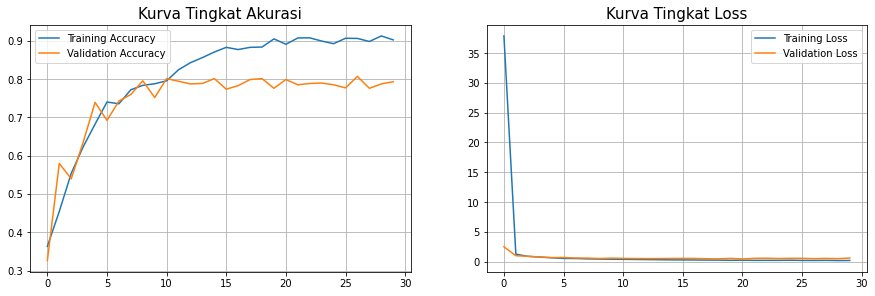

time: 298 ms (started: 2021-02-22 03:49:11 +00:00)


In [16]:
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)
 
plt.subplot(2, 2, 1)
plt.plot(history.history["acc"], label = "Training Accuracy")
plt.plot(history.history["val_acc"], label="Validation Accuracy")
plt.legend()
plt.title("Kurva Tingkat Akurasi", size=15)
plt.grid(zorder=0)
 
plt.subplot(2, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Kurva Tingkat Loss", size=15)
plt.grid(zorder=0)
plt.show()

# Menggunakan Model

In [17]:
print(train_generator)

time: 957 µs (started: 2021-02-22 03:50:33 +00:00)


In [18]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

time: 1.39 ms (started: 2021-02-22 03:50:36 +00:00)


# Evaluasi Jaringan

In [19]:
#Menampilkan matriks yang benar dan matriks hasil prediksi
 
#Label yang benar
y_true = np.argmax(y_test2,axis=1)
 
#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
 
print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

# Membuat Confusion Matrix

Normalized confusion matrix
[[0.92 0.06 0.01]
 [0.05 0.94 0.01]
 [0.07 0.03 0.9 ]]


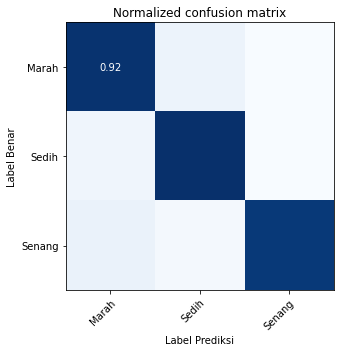

time: 166 ms (started: 2021-02-22 03:50:53 +00:00)


In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if not title:
    if normalize:
      title = 'Normalized confusion matrix'
    else:
      title = 'Confusion matrix, without normalization'

  #compute confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  #Only use the labels that appear in the data
  #classes = classes[unique_labels(y_true, y_pred)]
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np. newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  print(cm)

  fig, ax = plt.subplots(figsize=(5,5))
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  #ax.figure.colorbar(im, ax=ax)
  #we want to show all ticks...
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         #...and label them with the respective list entries
         xticklabels=classes, yticklabels=classes,
         title=title,
         ylabel='Label Benar',
         xlabel='Label Prediksi')
  
  #Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")
  #Loop over data dimensions and create text annotations.
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      ax.text(j, i, format(cm[i, j], fmt),
              ha="center", va="center",
              color="white" if cm[i, j] > thresh else "black")
      fig.tight_layout()
      return ax

np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

# Menyimpan dan Mengkonversi Model ke ".tflite"

In [21]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)
 
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()
 
with open('Emotion_Detection_MobileNet.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: save/model/assets
time: 15.8 s (started: 2021-02-22 03:52:03 +00:00)


# Menyimpan model tflite versi kompatibel quantized

In [ ]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)
 
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
 
with open('Emotion_Detection_MobileNet_Quantized', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: save/model/assets
time: 16.4 s (started: 2021-02-21 05:56:50 +00:00)


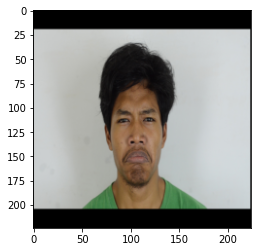

Label yang benar adalah: 1 : Sedih
Nilai yang diprediksi adalah: [0.01 0.99 0.  ]
Label yang diprediksi adalah: 1 : Sedih
Prediksi benar
time: 200 ms (started: 2021-02-22 03:52:39 +00:00)


In [23]:
n = 300
 
plt.imshow(X_test[n])
plt.show()
 
true_label = np.argmax(y_test2,axis=1) [n]
print("Label yang benar adalah:", true_label,":", labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])
 
if true_label == predicted_label:
  print("Prediksi benar")
else:
  print("Prediksi salah")

# Penggunaan Model Pada Gambar

In [24]:
import cv2
from google.colab.patches import cv2_imshow

time: 3.83 ms (started: 2021-02-22 03:52:45 +00:00)


Mendeteksi wajah...


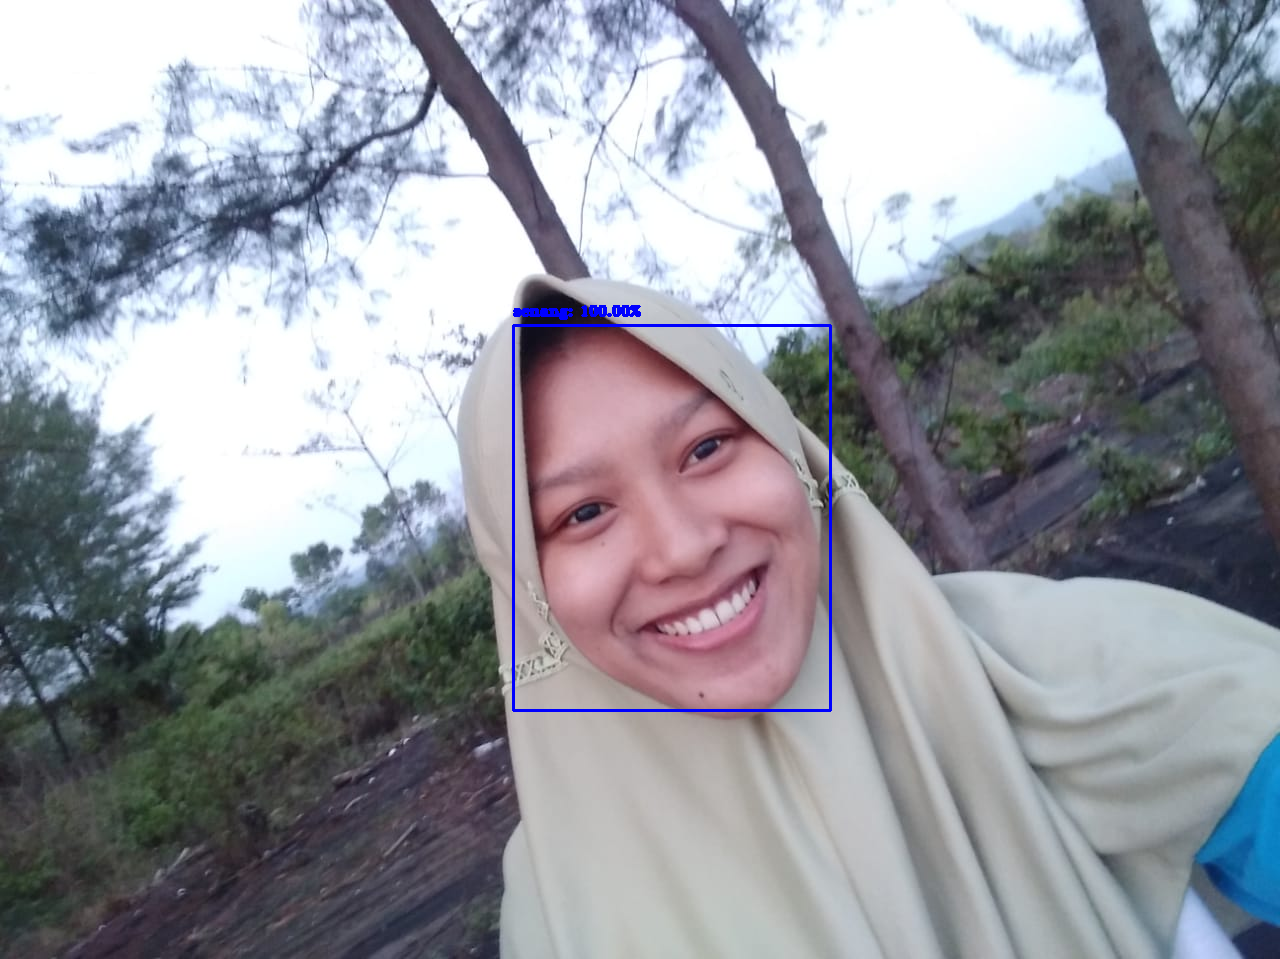

time: 577 ms (started: 2021-02-22 03:54:21 +00:00)


In [27]:
image = cv2.imread('/content/facedetector/Face Detector dan Contoh/Contoh/senang1 (1).jpeg')
orig = image.copy()
(h, w) = image.shape[:2]

blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))

net=cv2.dnn.readNet('/content/facedetector/Face Detector dan Contoh/deploy.prototxt', '/content/facedetector/Face Detector dan Contoh/res10_300x300_ssd_iter_140000.caffemodel')

# Melewatkan blob melalui jaringan dan mendapatkan deteksi wajah
print("Mendeteksi wajah...")
net.setInput(blob)
detections = net.forward()

for i in range(0, detections.shape[2]):
  # ekstrak keyakinan (yaitu, probabilitas) yang terkait dengan deteksi
  confidence = detections[0, 0, i, 2]
  
  if confidence > 0.5:
    # Menghitung koordinat (x, y) dari kotak pembatas untuk objek
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")
    
    # Memastikan kotak pembatas berada dalam dimensi bingkai
    (startX, startY) = (max(0, startX), max(0, startY))
    (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
    
    # Ekstrak ROI wajah, konversikan dari BGR ke pemesanan saluran RGB,
    # dan mengubah ukurannya menjadi 224x224, dan lalu pre-proses
    face = image[startY:endY, startX:endX]
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face = cv2.resize(face, (224, 224))
    face = img_to_array(face)
    face = preprocess_input(face)
    face = np.expand_dims(face, axis=0)
    # Membaca wajah dengan model
    (Marah, Sedih, Senang) = model.predict(face)[0]
    
    # Menggunakan masker hijau, tidak bermasker merah
    if (Marah>Sedih and Marah>Senang):
      label = "marah"
    elif (Sedih>Senang and Sedih>Marah):
      label = "sedih"
    elif (Senang>Sedih and Senang>Marah):
      label = "senang"
      
    if label == "sedih":
      color = (0, 255, 0)
    elif label == "marah":
      color = (0, 0, 255)
    elif label == "senang":
      color = (255, 0, 0)
      
    # Probabilitas hasil deteksi
    label = "{}: {:.2f}%".format(label, max(Marah, Sedih, Senang) * 100)
    
    # Menampilkan hasil dengan label dan kotak
    cv2.putText(image, label, (startX, startY - 10),
                cv2.FONT_HERSHEY_TRIPLEX, 0.45, color, 2)
    cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
    # Menampilkan output
    cv2_imshow(image)
    cv2.waitKey(0)
  

Menguji Model Secara Realtime

In [28]:
# Mengimport lib
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os
 
def detect_and_predict_emotion(frame, faceNet, emotionNet):
    # Membuat dimensi kotak deteksi
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
        (104.0, 177.0, 123.0))
 
    # Melewatkan blob dan mendeteksi wajah
    faceNet.setInput(blob)
    detections = faceNet.forward()
 
    # Inisialisasi
    faces = []
    locs = []
    preds = []
 
    for i in range(0, detections.shape[2]):
        # ekstrak keyakinan (yaitu, probabilitas) yang terkait dengan deteksi
        confidence = detections[0, 0, i, 2]
 
        if confidence > 0.5:
            # Menghitung koordinat (x, y) dari kotak pembatas untuk objek
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
 
            # Memastikan kotak pembatas berada dalam dimensi bingkai
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
 
            # Ekstrak ROI wajah, konversikan dari BGR ke pemesanan saluran RGB,
            # dan mengubah ukurannya menjadi 224x224, dan lalu pre-proses
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
 
            # Menambahkan kotak deteksi
            faces.append(face)
            locs.append((startX, startY, endX, endY))
 
    if len(faces) > 0:
        faces = np.array(faces, dtype="float32")
        preds = emotionNet.predict(faces, batch_size=32)
 
    return (locs, preds)
 
faceNet=cv2.dnn.readNet('/content/facedetector/Face Detector dan Contoh/deploy.prototxt', '/content/facedetector/Face Detector dan Contoh/res10_300x300_ssd_iter_140000.caffemodel')

time: 53.4 ms (started: 2021-02-22 03:57:38 +00:00)


In [29]:
import base64
import html
import io
import time
 
from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image
import cv2
 
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'Ketika selesai, klik disini atau pada video untuk berhenti dari demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')
 
  display(js)
  
def video_frame(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

time: 26.4 ms (started: 2021-02-22 03:57:45 +00:00)


In [30]:
def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam
    output: 
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    image_array = np.array(image_PIL)
 
    return image_array

time: 4.03 ms (started: 2021-02-22 03:57:52 +00:00)


<IPython.core.display.Javascript object>

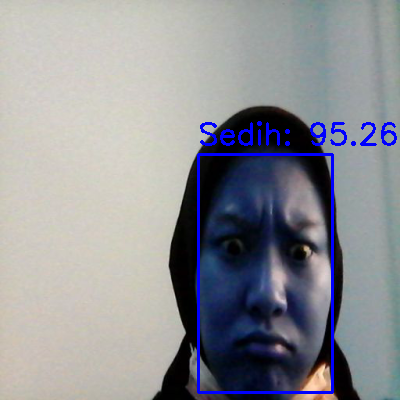

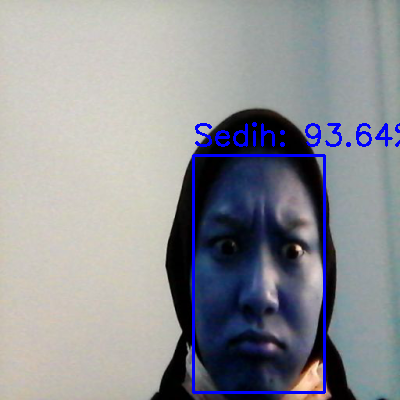

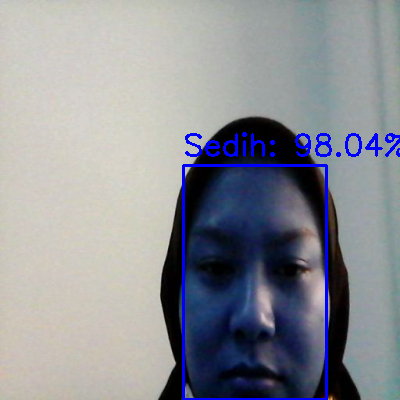

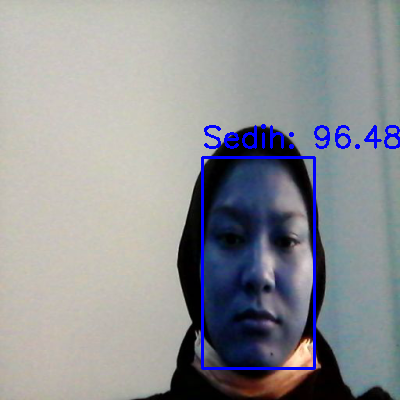

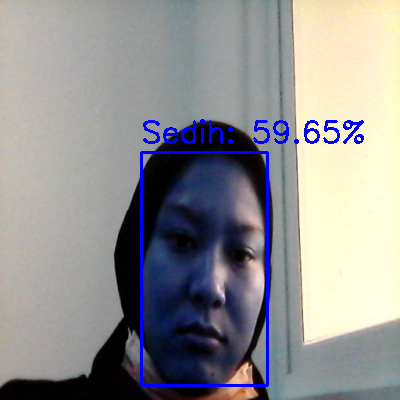

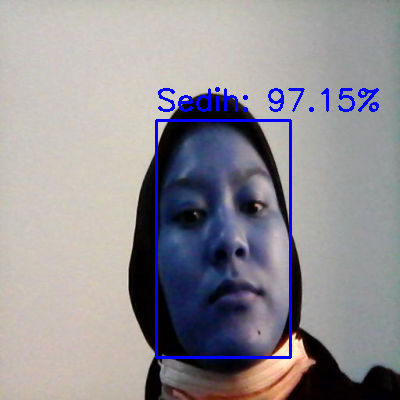

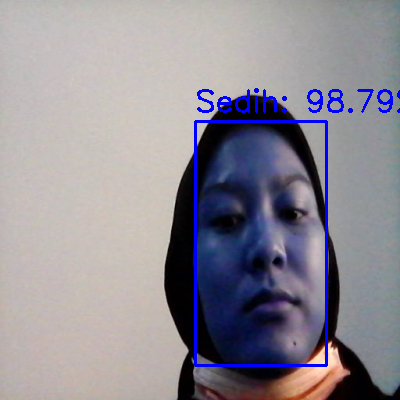

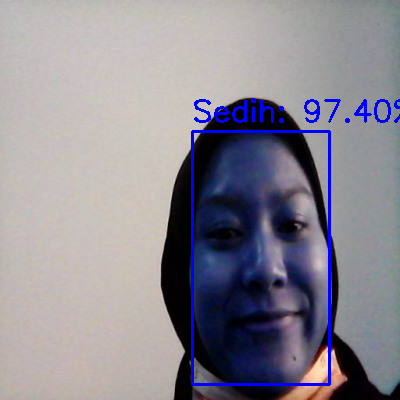

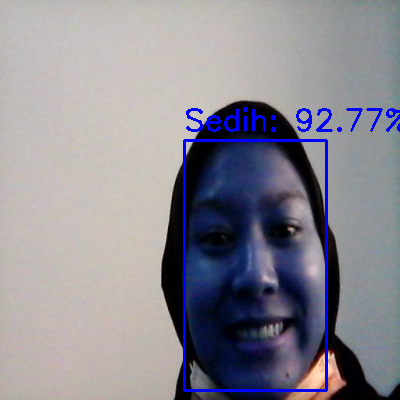

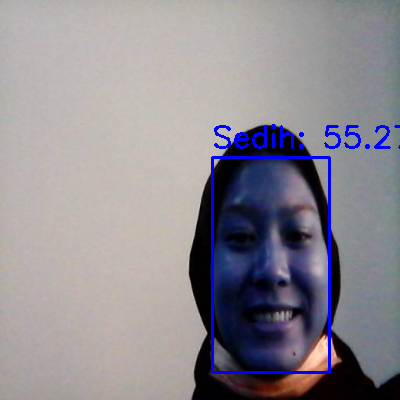

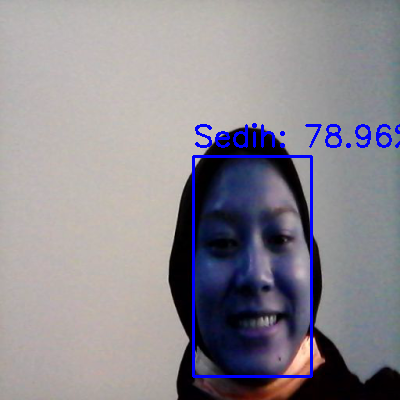

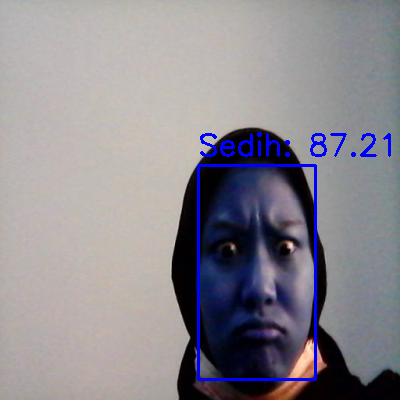

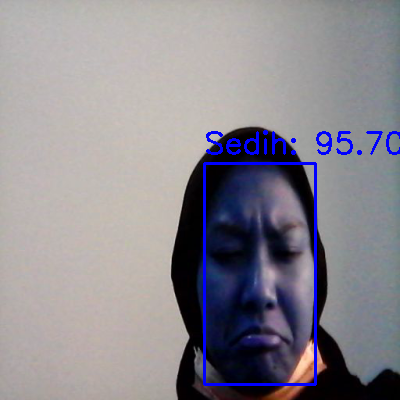

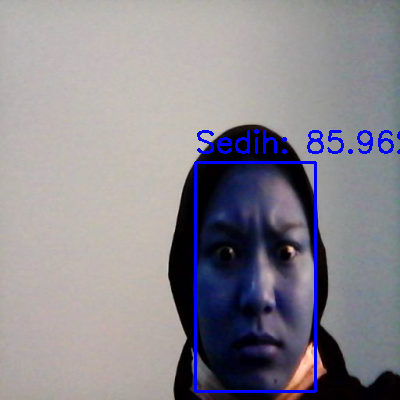

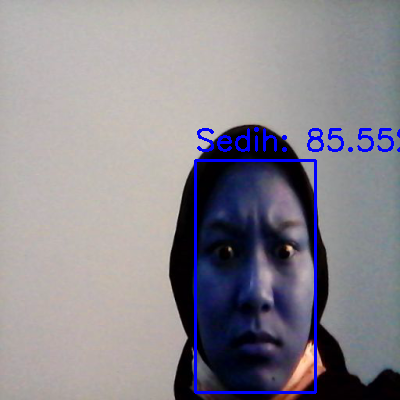

time: 33.7 s (started: 2021-02-22 04:00:20 +00:00)


In [32]:
video_stream()
label_html = 'Capturing...'
img_data = ''
count = 0 
from google.colab.patches import cv2_imshow
while True:
  js_reply = video_frame(label_html, img_data)
  if not js_reply:
    break
  
  image = js_reply_to_image(js_reply)
  
  # Mengambil frame dari aliran video berulir dan 
  # ukurannya maksimum lebar 400 pixel
  frame = image
  v=True
  if v == True:
    
    frame = imutils.resize(frame, width=400)
    
    # Mendeteksi emosi
    (locs, preds) = detect_and_predict_emotion(frame, faceNet, model)
    for (box, pred) in zip(locs, preds):
      
      # Membuka kotak dan prediksi
      (startX, startY, endX, endY) = box
      (Marah, Sedih, Senang) = pred
 
      # Menggunakan masker hijau, tidak bermasker merah
      if (Marah>Sedih and Marah>Senang):
        label = "Marah"
      elif (Sedih>Senang and Sedih>Marah):
        label = "Sedih"
      elif (Senang>Marah and Senang>Sedih):
        label = "senang"
        
      if label == "marah":
        color = (0, 255, 0)
      elif label == "sedih":
        color = (0, 0, 255)
      elif label == "senang" :
        color = (255, 0, 0)
        
      # Probabilitas pada label
      label = "{}: {:.2f}%".format(label, max(Marah, Sedih, Senang) * 100)
      
      # Menampilkan hasil dengan label dan kotak dari frame
      frame=cv2.putText(frame, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
      frame=cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
      # Menampilkan ouput
      cv2_imshow(frame)